# Analysis of dog performance vs weather conditions

## Data preprocessing

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns

pd.set_option('display.max_columns', None)

/tmp/ipykernel_81612/2336611746.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
races_df = pd.read_csv('races.csv')
races_df = races_df.replace('unknown', np.nan)
races_df.when = pd.to_datetime(races_df.when)
races_df.head(2)

,division,when,team1,team2,time_tot,win,hurdles,name1,start_chng1,time1,name2,start_chng2,time2,name3,start_chng3,time3,name4,start_chng4,time4,event,course_color
0,1,2023-04-22 10:11:57,WildRunners dreamers,WildRunners Maximini,17.01,L,25.0,Sunny,-0.24,4.21,Dixie,0.30,4.24,Alex,0.16,4.22,Hector,0.0,4.13,Hanácké škvarek (Heroltice),blue
1,1,2023-04-22 10:11:57,WildRunners Maximini,WildRunners dreamers,19.43,L,25.0,Brooke,-0.11,4.08,Rocky,1.29,5.15,Bella,0.23,4.52,Bree,0.0,4.28,Hanácké škvarek (Heroltice),red


In [3]:
df_run1 = races_df[['when', 'name1', 'start_chng1', 'time1']]
df_run2 = races_df[['when', 'name2', 'start_chng2', 'time2']]
df_run3 = races_df[['when', 'name3', 'start_chng3', 'time3']]
df_run4 = races_df[['when', 'name4', 'start_chng4', 'time4']]

col_names = ['when', 'name', 'start_chng', 'time']
df_run1.columns = col_names
df_run2.columns = col_names
df_run3.columns = col_names
df_run4.columns = col_names

df_run1 = df_run1.dropna()
df_run2 = df_run2.dropna()
df_run3 = df_run3.dropna()
df_run4 = df_run4.dropna()

df_runs_all = pd.concat([df_run1, df_run2, df_run3, df_run4], axis=0)
df_runs_all = df_runs_all[(df_runs_all.time <= 8) & (df_runs_all.time >= 3)]
df_runs_all = df_runs_all[df_runs_all.start_chng <= 8]
df_runs_all['total_time'] = np.where(df_runs_all.start_chng >= 0, df_runs_all.time + df_runs_all.start_chng, None)
df_runs_all['when'] = df_runs_all['when'].dt.round('20min')
df_runs_all.shape

(32502, 5)

In [4]:
df_runs_all.head()

,when,name,start_chng,time,total_time
0,2023-04-22 10:20:00,Sunny,-0.24,4.21,None
1,2023-04-22 10:20:00,Brooke,-0.11,4.08,None
2,2023-04-22 10:20:00,Sunny,0.02,4.25,4.27
3,2023-04-22 10:20:00,Brooke,-0.63,4.25,None
4,2023-04-22 10:20:00,Sunny,-0.06,4.21,None


In [5]:
weather_df = pd.read_csv('weather.csv')
weather_df['when'] = weather_df.apply(lambda x: pd.to_datetime(f'{x.date} {x.hour}:{x.minute}:00'), axis=1)
weather_df.drop(columns=['date', 'hour', 'minute'], inplace=True)
weather_df.head()

,city,temperature,feels_like,humidity,wind_speed,weather,rain,when
0,Heroltice,8.99,7.80,74,2.26,Clear,0.0,2023-04-22 08:00:00
1,Heroltice,10.14,9.04,70,2.26,Clear,0.0,2023-04-22 08:20:00
2,Heroltice,13.33,12.26,59,2.26,Clear,0.0,2023-04-22 08:40:00
3,Heroltice,11.86,10.80,65,2.26,Clear,0.0,2023-04-22 09:00:00
4,Heroltice,13.64,12.65,61,2.26,Clear,0.0,2023-04-22 09:20:00


In [6]:
df_runs_all = pd.merge(df_runs_all, weather_df, on='when', how='left')
df_runs_all.head()

,when,name,start_chng,time,total_time,city,temperature,feels_like,humidity,wind_speed,weather,rain
0,2023-04-22 10:20:00,Sunny,-0.24,4.21,None,Heroltice,16.49,15.45,48,2.58,Clear,0.0
1,2023-04-22 10:20:00,Brooke,-0.11,4.08,None,Heroltice,16.49,15.45,48,2.58,Clear,0.0
2,2023-04-22 10:20:00,Sunny,0.02,4.25,4.27,Heroltice,16.49,15.45,48,2.58,Clear,0.0
3,2023-04-22 10:20:00,Brooke,-0.63,4.25,None,Heroltice,16.49,15.45,48,2.58,Clear,0.0
4,2023-04-22 10:20:00,Sunny,-0.06,4.21,None,Heroltice,16.49,15.45,48,2.58,Clear,0.0


## Correlation matrix

In [7]:
df_runs_all.corr(numeric_only=True)

,start_chng,time,temperature,feels_like,humidity,wind_speed,rain
start_chng,1.000000,0.101514,0.015126,0.013714,-0.025127,-0.025438,-0.027122
time,0.101514,1.000000,0.052896,0.047792,-0.091432,-0.000246,-0.124700
temperature,0.015126,0.052896,1.000000,0.997317,-0.542768,-0.236159,0.046073
feels_like,0.013714,0.047792,0.997317,1.000000,-0.492249,-0.239879,0.069966
humidity,-0.025127,-0.091432,-0.542768,-0.492249,1.000000,-0.056608,0.357858
wind_speed,-0.025438,-0.000246,-0.236159,-0.239879,-0.056608,1.000000,-0.258720
rain,-0.027122,-0.124700,0.046073,0.069966,0.357858,-0.258720,1.000000


In [8]:
def corr_between(df, x, y):
    corr, p_value = pearsonr(df[x], df[y])
    print(f'Correlation between {x} and {y}: {corr:.4f}, p-value: {p_value:.6f}')

## Running time vs. temperature

The low p-value indicates a significant correlation between temperature and running time. However, even though the correlation is significant, the slope is very low. A 1°C increase in temperature corresponds to only a 0.004-second increase in running time.

Dog performance may improve by approximately 0.1 seconds on a cold day (< 10°C) compared to a hot day (> 30°C).

Visually examining the data suggests a stepwise performance degradation above 25°C. The run time of the best performing dogs abruptly changes from around 3.4 seconds to around 3.65 seconds. It's important to note, however, that lower performing days or events also occur at lower temperatures. Additionally, there are very few slow runs (> 6.5 seconds) on cold days (< 10°C) compared to many slower runs on warm days.

Overall, it seems reasonable to conclude that dog performance increases with lower temperatures.


In [9]:
corr_between(df_runs_all, 'time', 'temperature')

Correlation between time and temperature: 0.0529, p-value: 0.000000


Slope: 0.004428629736490159, Intercept: 4.29003328296098


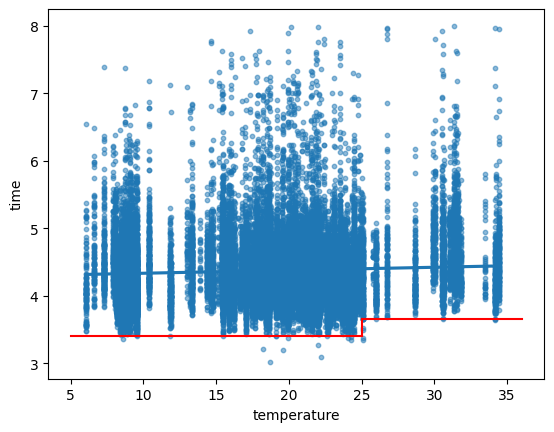

In [17]:
slope, intercept = np.polyfit(df_runs_all['temperature'], df_runs_all['time'], 1)
print(f'Slope: {slope}, Intercept: {intercept}')
sns.regplot(x='temperature', y='time', data=df_runs_all, scatter_kws={'s': 10, 'alpha': 0.5})
plt.plot([5, 25], [3.4, 3.4], color='red')
plt.plot([25, 25], [3.4, 3.66], color='red')
plt.plot([25, 36], [3.65, 3.65], color='red')

## Running time vs. humidity

The low p-value indicates a significant correlation between humidity and running time. A 1% increase in humidity leads to dogs running slightly faster by approximately 0.003 seconds. Comparing a very dry day (humidity around 30%) with a wet, likely rainy day (humidity 90-100%), the difference in average running time could be more than 0.2 seconds.

However, correlation does not equal causation. It's possible that other factors associated with high humidity, such as lower temperatures or rain, are actually improving dog performance.

In [10]:
corr_between(df_runs_all, 'time', 'humidity')

Correlation between time and humidity: -0.0914, p-value: 0.000000


Slope: -0.003364590798523047, Intercept: 4.587177326594019


<Axes: xlabel='humidity', ylabel='time'>

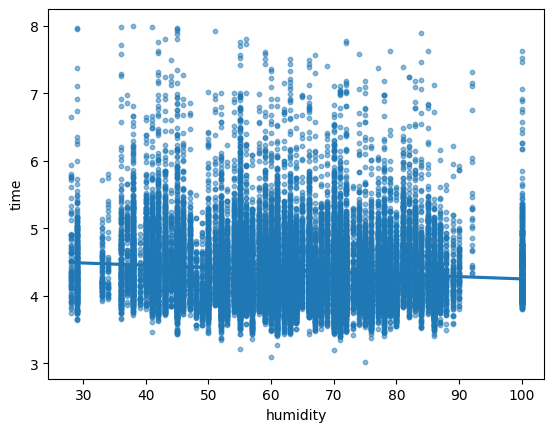

In [18]:
slope, intercept = np.polyfit(df_runs_all['humidity'], df_runs_all['time'], 1)
print(f'Slope: {slope}, Intercept: {intercept}')
sns.regplot(x='humidity', y='time', data=df_runs_all, scatter_kws={'s': 10, 'alpha': 0.5})

## Running time vs. wind speed

The high p-value indicates that there is NO significant correlation between the 
wind speed and the running time.

In [11]:
corr_between(df_runs_all, 'time', 'wind_speed')

Correlation between time and wind_speed: -0.0002, p-value: 0.964567


Slope: -8.665769543797104e-05, Intercept: 4.374277904356773


<Axes: xlabel='wind_speed', ylabel='time'>

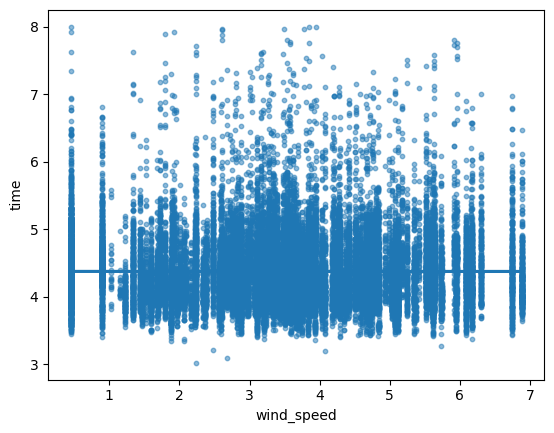

In [19]:
slope, intercept = np.polyfit(df_runs_all['wind_speed'], df_runs_all['time'], 1)
print(f'Slope: {slope}, Intercept: {intercept}')
sns.regplot(x='wind_speed', y='time', data=df_runs_all, scatter_kws={'s': 10, 'alpha': 0.5})

## Running time vs. rain intensity

The low p-value indicates that there is a significant correlation between 
rain intensity and running time. It seems that dogs run faster on a rainy 
day with a 1 mm increase in rain corresponding to a decrease in running time of 
about 0.14 seconds.

Visually examining the data suggests rain may not affect peak performance. 
However, it seems to eliminate slow performances. There are many runs exceeding 
5.5-6 seconds on dry days, but these longer runs become much rarer during rain.

In [12]:
corr_between(df_runs_all, 'time', 'rain')

Correlation between time and rain: -0.1247, p-value: 0.000000


Slope: -0.13706532054967518, Intercept: 4.396212766190036


<Axes: xlabel='rain', ylabel='time'>

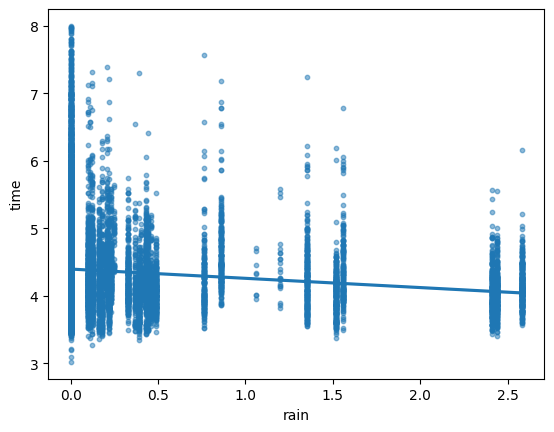

In [20]:
slope, intercept = np.polyfit(df_runs_all['rain'], df_runs_all['time'], 1)
print(f'Slope: {slope}, Intercept: {intercept}')
sns.regplot(x='rain', y='time', data=df_runs_all, scatter_kws={'s': 10, 'alpha': 0.5})